In [ ]:
!pip install prophet

In [ ]:
!pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import yfinance as yf
from prophet import Prophet
import mplfinance as mpf
import matplotlib.pyplot as plt

In [ ]:
tickers = ['BTC-USD', 'ETH-USD']
start_date = '2023-01-01'
end_date = '2024-08-27'
data = yf.download(tickers, start=start_date, end=end_date, interval='1h')

[*********************100%***********************]  2 of 2 completed


In [ ]:
print("Columns in data:", data.columns)

Columns in data: MultiIndex([('Adj Close', 'BTC-USD'),
            ('Adj Close', 'ETH-USD'),
            (    'Close', 'BTC-USD'),
            (    'Close', 'ETH-USD'),
            (     'High', 'BTC-USD'),
            (     'High', 'ETH-USD'),
            (      'Low', 'BTC-USD'),
            (      'Low', 'ETH-USD'),
            (     'Open', 'BTC-USD'),
            (     'Open', 'ETH-USD'),
            (   'Volume', 'BTC-USD'),
            (   'Volume', 'ETH-USD')],
           names=['Price', 'Ticker'])


In [ ]:
def prepare_data(data, ticker):
    if ('Open', ticker) not in data.columns:
        raise KeyError(f"Ticker {ticker} not found in data")

    df = data[['Open', 'High', 'Low', 'Close', 'Volume']].loc[:, (slice(None), ticker)].dropna().reset_index()
    df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    df.set_index('Date', inplace=True)
    return df

btc_data = prepare_data(data, 'BTC-USD')
eth_data = prepare_data(data, 'ETH-USD')

In [ ]:
def forecast_next_hour(data):
    prophet_data = data[['Close']].reset_index()
    prophet_data.columns = ['ds', 'y']
    prophet_data['ds'] = prophet_data['ds'].dt.tz_localize(None)

    model = Prophet()
    model.fit(prophet_data)

    # Create future DataFrame with only next hour
    future = model.make_future_dataframe(periods=1, freq='H')
    forecast = model.predict(future)
    forecast['ds'] = forecast['ds'].dt.tz_localize(None)

    # Get the prediction for the next hour
    next_hour_forecast = forecast.iloc[-1]
    return next_hour_forecast['yhat'], next_hour_forecast['yhat_upper'], next_hour_forecast['yhat_lower']

# Forecast for BTC
btc_current_price = btc_data['Close'].iloc[-1]
btc_predicted_price, btc_predicted_upper, btc_predicted_lower = forecast_next_hour(btc_data)
btc_color = 'green' if btc_predicted_price > btc_current_price else 'red'

# Forecast for ETH
eth_current_price = eth_data['Close'].iloc[-1]
eth_predicted_price, eth_predicted_upper, eth_predicted_lower = forecast_next_hour(eth_data)
eth_color = 'green' if eth_predicted_price > eth_current_price else 'red'


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp62n5_62r/eeln5oni.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp62n5_62r/9k6gxhpz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22320', 'data', 'file=/tmp/tmp62n5_62r/eeln5oni.json', 'init=/tmp/tmp62n5_62r/9k6gxhpz.json', 'output', 'file=/tmp/tmp62n5_62r/prophet_modellfyau_1n/prophet_model-20240828083304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:33:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:33:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/t

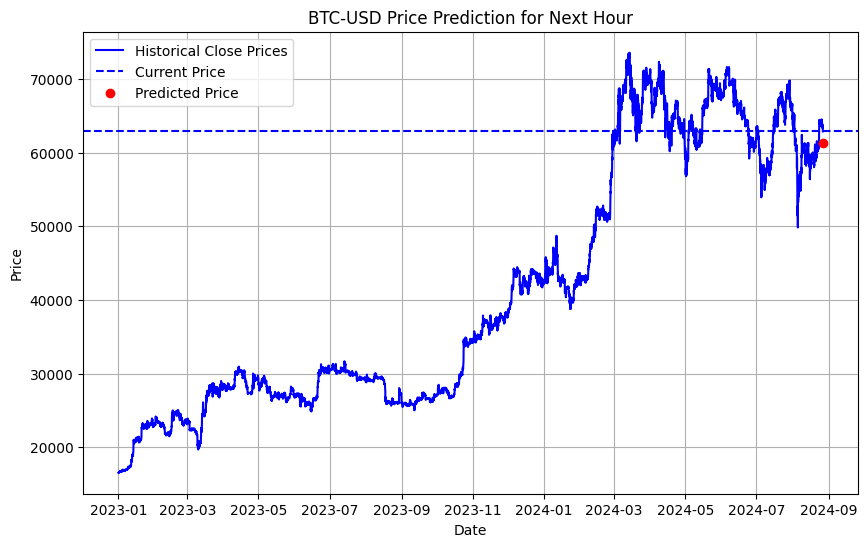

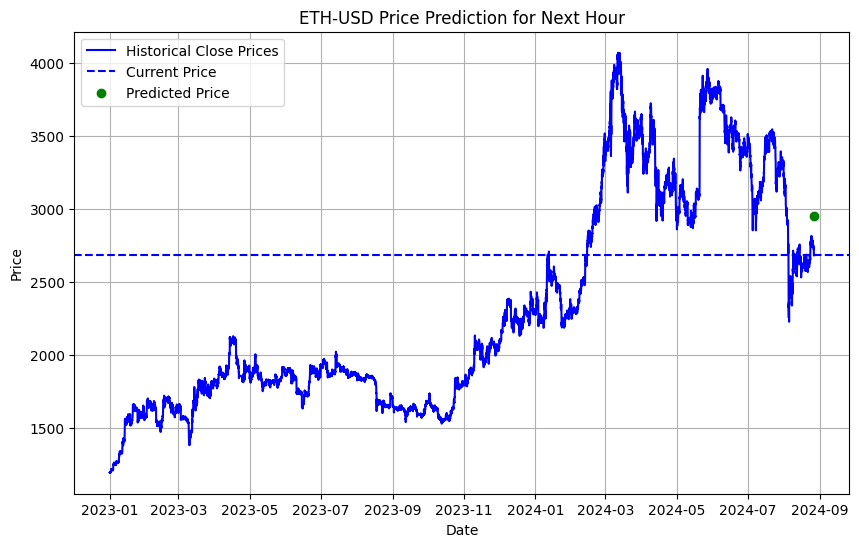

In [ ]:
def plot_prediction(data, current_price, predicted_price, color, title):
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['Close'], label='Historical Close Prices', color='blue')
    plt.axhline(y=current_price, color='blue', linestyle='--', label='Current Price')
    plt.scatter(data.index[-1] + pd.DateOffset(hours=1), predicted_price, color=color, label='Predicted Price', zorder=5)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_prediction(btc_data, btc_current_price, btc_predicted_price, btc_color, 'BTC-USD Price Prediction for Next Hour')
plot_prediction(eth_data, eth_current_price, eth_predicted_price, eth_color, 'ETH-USD Price Prediction for Next Hour')